<a href="https://colab.research.google.com/github/evansemet/Jane-Street-Solutions/blob/main/2016_05_Hooks_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [293]:
!pip install z3-solver
from copy import copy, deepcopy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from z3 import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [294]:
row_tot = np.array([45, 44, 4, 48, 7, 14, 47, 43, 33], dtype=int)
col_tot = np.array([36, 5, 47, 35, 17, 30, 21, 49, 45], dtype=int)

In [295]:
nine0 = np.array([[9,9,9,9,9,9,9,9,9],
                  [0,0,0,0,0,0,0,0,9],
                  [0,0,0,0,0,0,0,0,9],
                  [0,0,0,0,0,0,0,0,9],
                  [0,0,0,0,0,0,0,0,9],
                  [0,0,0,0,0,0,0,0,9],
                  [0,0,0,0,0,0,0,0,9],
                  [0,0,0,0,0,0,0,0,9],
                  [0,0,0,0,0,0,0,0,9]], dtype=int)

eight0 = np.array([[8,8,8,8,8,8,8,8],
                   [0,0,0,0,0,0,0,8],
                   [0,0,0,0,0,0,0,8],
                   [0,0,0,0,0,0,0,8],
                   [0,0,0,0,0,0,0,8],
                   [0,0,0,0,0,0,0,8],
                   [0,0,0,0,0,0,0,8],
                   [0,0,0,0,0,0,0,8]], dtype=int)

seven0 = np.array([[7,7,7,7,7,7,7],
                   [0,0,0,0,0,0,7],
                   [0,0,0,0,0,0,7],
                   [0,0,0,0,0,0,7],
                   [0,0,0,0,0,0,7],
                   [0,0,0,0,0,0,7],
                   [0,0,0,0,0,0,7]], dtype=int)

six0 = np.array([[6,6,6,6,6,6],
                 [0,0,0,0,0,6],
                 [0,0,0,0,0,6],
                 [0,0,0,0,0,6],
                 [0,0,0,0,0,6],
                 [0,0,0,0,0,6]], dtype=int)

five0 = np.array([[5,5,5,5,5],
                  [0,0,0,0,5],
                  [0,0,0,0,5],
                  [0,0,0,0,5],
                  [0,0,0,0,5]], dtype=int)

four0 = np.array([[4,4,4,4],
                  [0,0,0,4],
                  [0,0,0,4],
                  [0,0,0,4]], dtype=int)

three0 = np.array([[3,3,3],
                   [0,0,3],
                   [0,0,3]], dtype=int)

two0 = np.array([[2,2],
                 [0,2]], dtype=int)

In [296]:
def rotate(A):
  B = deepcopy(A); N = len(B[0])
  for i in range(N // 2):
    for j in range(i, N - i - 1):
      temp = B[i][j]
      B[i][j] = B[N - 1 - j][i]
      B[N - 1 - j][i] = B[N - 1 - i][N - 1 - j]
      B[N - 1 - i][N - 1 - j] = B[j][N - 1 - i]
      B[j][N - 1 - i] = temp
  return B

nine1 = rotate(nine0); nine2 = rotate(nine1); nine3 = rotate(nine2)
nines = [nine0, nine1, nine2, nine3]

eight1 = rotate(eight0); eight2 = rotate(eight1); eight3 = rotate(eight2)
eights = [eight0, eight1, eight2, eight3]

seven1 = rotate(seven0); seven2 = rotate(seven1); seven3 = rotate(seven2)
sevens = [seven0, seven1, seven2, seven3]

six1 = rotate(six0); six2 = rotate(six1); six3 = rotate(six2)
sixes = [six0, six1, six2, six3]

five1 = rotate(five0); five2 = rotate(five1); five3 = rotate(five2)
fives = [five0, five1, five2, five3]

four1 = rotate(four0); four2 = rotate(four1); four3 = rotate(four2)
fours = [four0, four1, four2, four3]

three1 = rotate(three0); three2 = rotate(three1); three3 = rotate(three2)
threes = [three0, three1, three2, three3]

two1 = rotate(two0); two2 = rotate(two1); two3 = rotate(two2)
twos = [two0, two1, two2, two3]

In [297]:
def grid_combos():
  grids = []
  #we know that the eight and nine can only go in one position
  for a in range(4):
    for b in range(4):
      for c in range(4):
        for d in range(4):
          for e in range(4):
            for f in range(4):
              grid = [0,1,a,b,c,d,e,f]
              grids.append(grid)
  return grids

possible_grids = grid_combos()

In [298]:
def solve(possible):
  Y = np.array(IntVector("y", 9**2), dtype=object).reshape((9, 9))
  s = Solver()

  for n in range(1, 10):
    s += PbEq([(Y[i][j] == n, 1) for j in range(9) for i in range(9)], n * 2 - 1)

  # we already knew where the 8 and 9 hook went
  s += And([Xor(Y[i][j] == int(val), Y[i][j] == 0) for (i,j),val in np.ndenumerate(nines[possible[0]]) if val])
  s += And([Xor(Y[i+1][j] == int(val), Y[i][j] == 0) for (i,j),val in np.ndenumerate(eights[possible[1]]) if val])

  # place the 7 hook
  s += And([(Y[i+1][j] == int(val)) for (i,j),val in np.ndenumerate(sevens[possible[2]]) if val])

  # place the 6 hook
  six_hooks = []
  for b in range(1,4):
    for c in range(2):
      six_hooks.append(And([(Y[i+b][j+c] == int(val)) for (i,j),val in np.ndenumerate(sixes[possible[3]]) if val]))
  s += PbEq([(hook, 1) for hook in six_hooks], 1)

  # place the 5 hook
  five_hooks = []
  for b in range(1,5):
    for c in range(3):
      five_hooks.append(And([(Y[i+b][j+c] == int(val)) for (i,j),val in np.ndenumerate(fives[possible[4]]) if val]))
  s += PbEq([(hook, 1) for hook in five_hooks], 1)

  # place the 4 hook
  four_hooks = []
  for b in range(1,6):
    for c in range(4):
      four_hooks.append(And([(Y[i+b][j+c] == int(val)) for (i,j),val in np.ndenumerate(fours[possible[5]]) if val]))
  s += PbEq([(hook, 1) for hook in four_hooks], 1)

  # place the 3 hook
  three_hooks = []
  for b in range(1,7):
    for c in range(5):
      three_hooks.append(And([(Y[i+b][j+c] == int(val)) for (i,j),val in np.ndenumerate(threes[possible[6]]) if val]))
  s += PbEq([(hook, 1) for hook in three_hooks], 1)

  # place the 2 hook
  two_hooks = []
  for b in range(1,8):
    for c in range(6):
      two_hooks.append(And([(Y[i+b][j+c] == int(val)) for (i,j),val in np.ndenumerate(twos[possible[7]]) if val]))
  s += PbEq([(hook, 1) for hook in two_hooks], 1)

  X = np.array(IntVector("x", 9**2), dtype=object).reshape((9, 9))
  # makes sure each number is from 0 to 9 and the sums match the given values
  s += [And(val >= 0, val <= 9) for val in X.ravel()]
  s += [np.sum(X[r, :]) == int(e) for r, e in np.ndenumerate(row_tot)]
  s += [np.sum(X[:, c]) == int(e) for c, e in np.ndenumerate(col_tot)]

  # make sure that each number is either the same as in Y or 0
  s += [Xor(val == 0, val == Y[i][j]) for (i,j),val in np.ndenumerate(X)]

  # only n instances of n  
  for n in range(1, 10):
    s += PbEq([(X[i][j] == n, 1) for j in range(9) for i in range(9)], n)
  
  if s.check() == sat:
    m = s.model()
    evalu = np.vectorize(lambda x: m.evaluate(x).as_long())
    r = evalu(X)
    r2 = evalu(Y)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax = sns.heatmap(r2, annot=r, cbar=False, cmap="tab20", linecolor='k', linewidth=2, annot_kws={"fontsize":14})
    ax.axis("off")
    return True
  else:
    return False

Solved in 812.9403803348541 seconds.


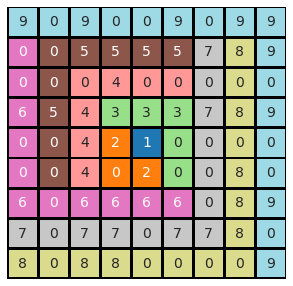

In [299]:
start = time.time()
solved = False
for trial in range(len(possible_grids)):
  if solve(possible_grids[trial]):
    solved = True
    break
if solved:
  print(f"Solved in {time.time() - start} seconds.") 
else:
  print(f"Failed in {time.time() - start} seconds.")